In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Загрузка данных

In [3]:
path = "/content/gdrive/MyDrive/ML/Datasets/titanic/train.csv"
data = pd.read_csv(path, sep = ",")               

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
X = data.drop(["Survived"], axis = 1)     # Резделим признаки и целевую переменную, это необходимо для удобства использования методов анализа данных.
y = data.Survived

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

#Предварительная обработка данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!git clone https://github.com/MazalTovGeksli/Imputation_missing_values.git
!pip install missingpy
!pip install category_encoders

import Imputation_missing_values.Imputation_missing_values.Imputation_missing_values as imv
from category_encoders import OneHotEncoder
import re

fatal: destination path 'Imputation_missing_values' already exists and is not an empty directory.


##Разные функции

In [ ]:
def PreProcess_for_Name(data, col_Name):
  number_column_Name = data.columns.get_loc(col_Name)                        # Определяем индекс столбца с именами.
  Title_values = [re.sub("(.*, )|(\\..*)", "", x) for x in data[col_Name]]   # С помощью регулярных выражений формируем список типов обращений.
  data.insert(number_column_Name + 1, 'Title', Title_values)                 # Создаём новый столбец в данных, размещая его справа от столбца Name.
  return(data)

def select_deck(data, col_name):
  number_column_Name = data.columns.get_loc(col_name)

  data[col_name].fillna('', inplace = True)
  Deck_values = [x[0] if x != '' else 'X' for x in data.Cabin]

  data.insert(number_column_Name, 'Deck', Deck_values)
  data.Cabin = data.Cabin.replace('', np.nan)
  data.Deck = data.Deck.replace('', np.nan)

  return(data)

def count_family(data, list_name_columns):
  number_column_Name = data.columns.get_loc(list_name_columns[1])

  size_family = data[list_name_columns[0]] + data[list_name_columns[1]] + 1
  data.insert(number_column_Name - 1, 'Fsize', size_family)

  size_family_discrete = ['large' if x > 4 else 'small' if (x < 5) & (x > 1) else 'singleton' for x in data.Fsize]
  data.insert(number_column_Name, 'FsizeDiscrete', size_family_discrete)

  return(data)

def Sex_and_FsizeDiscrete_encoding(data):
  data.Sex[data.Sex == "male"] = 0
  data.Sex[data.Sex == "female"] = 1
  data.Sex = data.Sex.astype(int)

  data.FsizeDiscrete[data.FsizeDiscrete == "singleton"] = 0
  data.FsizeDiscrete[data.FsizeDiscrete == "small"] = 1
  data.FsizeDiscrete[data.FsizeDiscrete == "large"] = 2
  data.FsizeDiscrete = data.FsizeDiscrete.astype(int)

  return(data)

def preProcess_train_test(train, test):
  train = PreProcess_for_Name(train, "Name")
  test = PreProcess_for_Name(test, "Name")

  rare_title = train.Title.value_counts()[train.Title.value_counts() < 20].index  # Эта переменная нам ещё понадобиться, ведь редкие обращения могут быть и в тестовых данных.
  train.Title = train.Title.replace(rare_title, 'Rare Title')
  test.Title = test.Title.replace(rare_title, 'Rare Title')

  train = count_family(train, ["SibSp", "Parch"])
  test = count_family(test, ["SibSp", "Parch"])

  train = select_deck(train, "Cabin")
  test = select_deck(test, "Cabin")

  train = train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
  test = test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)

  misscat = imv.Catman()
  misscat.fit(train.copy())

  train = misscat.transform(train.copy())
  test = misscat.transform(test.copy())

  train = Sex_and_FsizeDiscrete_encoding(train)
  test = Sex_and_FsizeDiscrete_encoding(test)

  object_list_feature = list(train.select_dtypes(include = 'object').columns)
  one_hot_enc = OneHotEncoder(cols = object_list_feature)
  train = one_hot_enc.fit_transform(train)
  test = one_hot_enc.transform(test)

  return(train, test)

##Отбор информативных признаков

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

def select_feature(model, data, label, l, plot_flag = True):
  res_f1 = []
  for i in l:
    select_k_best_classifier = SelectKBest(mutual_info_classif, k = i)
    X_new = select_k_best_classifier.fit_transform(data, label)
    X_new = pd.DataFrame(X_new)

    skf = KFold(n_splits = 5)
    f1 = []
    for train_index, test_index in skf.split(label):
      X_t = X_new.iloc[train_index]
      X_v = X_new.iloc[test_index]
      y_t = label[train_index]
      y_v = label[test_index]

      model.fit(X_t, y_t)
      preds = model.predict(X_t)
      f1.append(f1_score(y_t, preds))
    
    res_f1.append(np.mean(f1))
  feature_f1 = pd.DataFrame({'count_feature': l, 'f1': res_f1})

  if(plot_flag):
    sns.set(font_scale = 1.5)
    f, ax = plt.subplots(figsize=(15, 5))
    ax.set_xticks(range(2, 25, 2))
    sns.lineplot(data = feature_f1, x = "count_feature", y = "f1");
  
  kbest = feature_f1[feature_f1['f1'] == feature_f1.f1.max()].count_feature.reset_index(drop = True)

  return(kbest[0])

def n_best(train, test, label, n):
  select_k_best_classifier = SelectKBest(mutual_info_classif, n)
  train_best = select_k_best_classifier.fit_transform(train, label)
  train_best = pd.DataFrame(train_best, columns = list(train.columns[select_k_best_classifier.get_support()]))

  test_best = select_k_best_classifier.transform(test)
  test_best = pd.DataFrame(test_best, columns = list(test.columns[select_k_best_classifier.get_support()]))

  return(train_best, test_best)

#Демонстрация

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,701,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.5250,C62 C64,C
1,535,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S
2,672,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
3,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
4,354,3,"Arnold-Franchi, Mr. Josef",male,25.0,1,0,349237,17.8000,NaN,S


In [ ]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,853,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C
2,630,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
3,245,3,"Attalah, Mr. Sleiman",male,30.0,0,0,2694,7.2250,NaN,C
4,572,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S


In [ ]:
X_train, X_test = preProcess_train_test(X_train, X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [ ]:
X_train.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,1,1,0,0,0,0,1,18.0,2,1,1,0,227.5250,1,0,0,0,0,0,0,0,1,0,0
1,3,0,1,0,0,0,1,30.0,1,0,0,0,8.6625,0,1,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,31.0,2,1,1,0,52.0000,0,0,1,0,0,0,0,0,0,1,0
3,3,0,0,1,0,0,0,45.0,1,0,0,0,6.9750,0,1,0,0,0,0,0,0,0,1,0
4,3,0,0,1,0,0,0,25.0,2,1,1,0,17.8000,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
X_test.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,1,1,0,0,0,0,0,54.000000,1,0,0,0,51.8625,0,1,0,0,0,0,0,0,1,0,0
1,3,0,0,1,0,0,1,9.000000,3,1,1,1,15.2458,1,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,0,0,38.010917,1,0,0,0,7.7333,1,0,0,0,0,0,0,0,0,0,1
3,3,1,0,0,0,0,0,30.000000,1,0,0,0,7.2250,1,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,1,53.000000,3,1,2,0,51.4792,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
X_test.shape

(179, 24)

#Обучение модели

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

##Метод опорных векторов

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train.shape

(712, 24)

In [ ]:
X_train.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,3,1,0,0,0,0,0,32.580205,1,0,0,0,7.2500,1,0,0,0,0,0,0,0,1,0,0
1,3,1,0,0,0,0,0,34.000000,1,0,0,0,8.0500,1,0,0,0,0,0,0,0,1,0,0
2,3,1,0,0,0,0,0,27.000000,1,0,0,0,6.9750,1,0,0,0,0,0,0,0,1,0,0
3,3,0,1,0,0,0,1,45.000000,2,1,0,1,14.4542,1,0,0,0,0,0,0,0,0,1,0
4,3,1,0,0,0,0,0,32.000000,1,0,0,0,8.0500,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
model_SVC = SVC(kernel = 'linear')

In [ ]:
len(list(range(2, 25, 2)))

12

CPU times: user 5min 8s, sys: 672 µs, total: 5min 8s
Wall time: 5min 9s


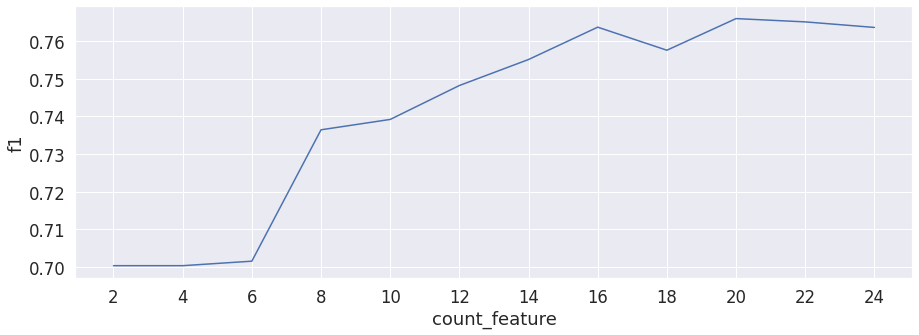

In [ ]:
%%time
res_svm = select_feature(model_SVC, X_train.copy(), y_train.copy(), list(range(2, 25, 2)), plot_flag = True)

In [ ]:
%%time
scaler = StandardScaler()

X_train_standard = scaler.fit_transform(X_train) 
X_test_standard = scaler.transform(X_test)

X_train_standard = pd.DataFrame(X_train_standard, columns = X_train.columns) 
X_test_standard = pd.DataFrame(X_test_standard, columns = X_test.columns) 

CPU times: user 5.95 ms, sys: 99 µs, total: 6.05 ms
Wall time: 10.6 ms


18
CPU times: user 2.95 s, sys: 9.92 ms, total: 2.96 s
Wall time: 2.98 s


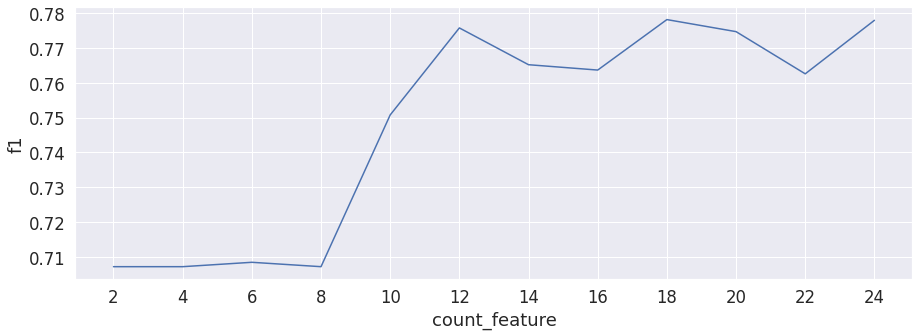

In [ ]:
%%time
res_svm1 = select_feature(model_SVC, X_train_standard.copy(), y_train.copy(), list(range(2, 25, 2)))
print(res_svm1)

In [ ]:
X_train_svm, X_test_svm = n_best(X_train_standard, X_test_standard, y_train, res_svm1)

In [ ]:
X_train_svm.head()

,Pclass,Title_1,Title_2,Title_3,Title_5,Sex,Age,Fsize,FsizeDiscrete,Fare,Deck_1,Deck_3,Deck_5,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,0.817022,0.865671,-0.404226,-0.514445,-0.182707,-0.742427,0.239495,-0.560897,-0.744136,-0.482993,0.529694,-0.268866,-0.119352,-0.182707,-0.125267,0.627173,-0.485913,-0.31696
1,0.817022,0.865671,-0.404226,-0.514445,-0.182707,-0.742427,0.344667,-0.560897,-0.744136,-0.467715,0.529694,-0.268866,-0.119352,-0.182707,-0.125267,0.627173,-0.485913,-0.31696
2,0.817022,0.865671,-0.404226,-0.514445,-0.182707,-0.742427,-0.173863,-0.560897,-0.744136,-0.488245,0.529694,-0.268866,-0.119352,-0.182707,-0.125267,0.627173,-0.485913,-0.31696
3,0.817022,-1.155174,2.473863,-0.514445,-0.182707,1.346933,1.159499,0.059225,0.846930,-0.345414,0.529694,-0.268866,-0.119352,-0.182707,-0.125267,-1.594456,2.057983,-0.31696
4,0.817022,0.865671,-0.404226,-0.514445,-0.182707,-0.742427,0.196516,-0.560897,-0.744136,-0.467715,-1.887883,-0.268866,-0.119352,-0.182707,-0.125267,0.627173,-0.485913,-0.31696


In [ ]:
parameters_SVC = {'C':[.3, .4, .5, .6, .7, 1, 1.5]}
model_SVC = SVC(kernel = 'linear')

In [ ]:
%%time
clf = GridSearchCV(estimator = model_SVC, param_grid = parameters_SVC, cv = 5, scoring = "f1")
clf.fit(X_train_svm, y_train)

CPU times: user 601 ms, sys: 0 ns, total: 601 ms
Wall time: 610 ms


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 1}
0.7605704416545636


In [ ]:
pd.DataFrame(clf.cv_results_)

In [ ]:
model_SVC = SVC(C = 1, kernel = 'linear')

In [ ]:
model_SVC.fit(X_train_svm, y_train)
pred_svm = model_SVC.predict(X_test_svm)

In [ ]:
f1_score_svm = f1_score(y_test, pred_svm)
f1_score_svm

0.7938931297709925

In [ ]:
confusion_matrix(y_test, pred_svm)

array([[100,  10],
       [ 17,  52]])

## k-ближайщих соседа

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train.shape

(712, 24)

In [ ]:
X_train.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,3,1,0,0,0,0,0,32.580205,1,0,0,0,7.2500,1,0,0,0,0,0,0,0,1,0,0
1,3,1,0,0,0,0,0,34.000000,1,0,0,0,8.0500,1,0,0,0,0,0,0,0,1,0,0
2,3,1,0,0,0,0,0,27.000000,1,0,0,0,6.9750,1,0,0,0,0,0,0,0,1,0,0
3,3,0,1,0,0,0,1,45.000000,2,1,0,1,14.4542,1,0,0,0,0,0,0,0,0,1,0
4,3,1,0,0,0,0,0,32.000000,1,0,0,0,8.0500,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
model_KNN = KNeighborsClassifier(n_jobs = -1)

CPU times: user 3.42 s, sys: 47.7 ms, total: 3.46 s
Wall time: 9.16 s


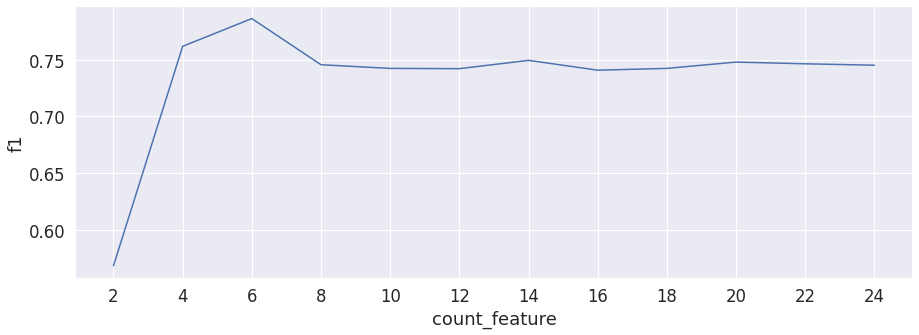

In [ ]:
%%time
res_knn = select_feature(model_KNN, X_train.copy(), y_train.copy(), list(range(2, 25, 2)))

In [ ]:
scaler = MinMaxScaler()
X_train_standard = scaler.fit_transform(X_train) 
X_test_standard = scaler.transform(X_test)
X_train_standard = pd.DataFrame(X_train_standard, columns = X_train.columns) 
X_test_standard = pd.DataFrame(X_test_standard, columns = X_test.columns) 

CPU times: user 3.69 s, sys: 46.3 ms, total: 3.74 s
Wall time: 9.16 s


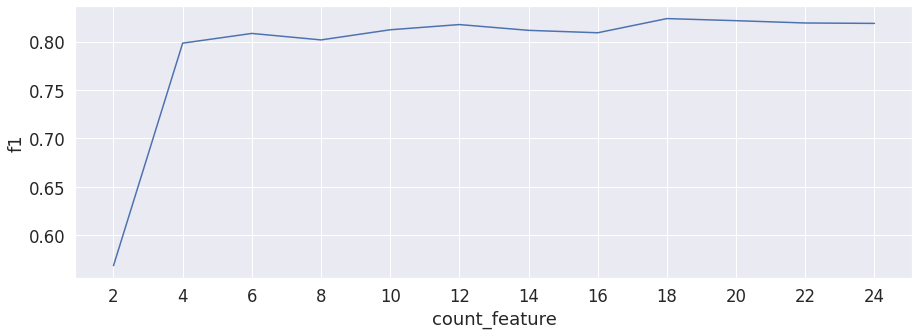

In [ ]:
%%time
res_knn1 = select_feature(model_KNN, X_train_standard.copy(), y_train.copy(), list(range(2, 25, 2)))

In [ ]:
res_knn1

18

In [ ]:
X_train_knn, X_test_knn = n_best(X_train_standard, X_test_standard, y_train, res_knn1)

In [ ]:
X_train_knn.head()

,Pclass,Title_1,Title_2,Title_3,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_4,Deck_6,Deck_8,Embarked_3
0,1.0,1.0,0.0,0.0,0.0,0.0,0.437078,0.0,0.0,0.0,0.0,0.014151,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.456374,0.0,0.0,0.0,0.0,0.015713,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.361239,0.0,0.0,0.0,0.0,0.013614,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.605871,0.1,0.5,0.0,0.2,0.028213,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.429193,0.0,0.0,0.0,0.0,0.015713,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
parameters_KNN = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 4, 5, 6, 7], 'algorithm':["auto", "ball_tree", "kd_tree", "brute"], "p":[1, 2, 3, 4, 5]}
model_KNN = KNeighborsClassifier(n_jobs = -1)

In [ ]:
%%time
clf = GridSearchCV(estimator = model_KNN, param_grid = parameters_KNN, cv = 5, scoring = "f1")
clf.fit(X_train_knn, y_train)

CPU times: user 25.8 s, sys: 5.41 s, total: 31.2 s
Wall time: 50.1 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'algorithm': 'auto', 'n_neighbors': 7, 'p': 4, 'weights': 'uniform'}
0.7835096152477482


In [ ]:
pd.DataFrame(clf.cv_results_)

In [ ]:
model_KNN = KNeighborsClassifier(n_jobs = -1, algorithm = 'auto', n_neighbors = 7, p = 4, weights = 'uniform')

In [ ]:
model_KNN.fit(X_train_knn, y_train)
pred_knn = model_KNN.predict(X_test_knn)

In [ ]:
f1_score_knn = f1_score(y_test, pred_knn)
f1_score_knn

0.7555555555555555

In [ ]:
confusion_matrix(y_test, pred_knn)

array([[95, 15],
       [18, 51]])

## Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_1,Embarked_2,Embarked_3
0,1,1,0,0,0,0,1,18.0,2,1,1,0,227.5250,1,0,0,0,0,0,0,0,1,0,0
1,3,0,1,0,0,0,1,30.0,1,0,0,0,8.6625,0,1,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,31.0,2,1,1,0,52.0000,0,0,1,0,0,0,0,0,0,1,0
3,3,0,0,1,0,0,0,45.0,1,0,0,0,6.9750,0,1,0,0,0,0,0,0,0,1,0
4,3,0,0,1,0,0,0,25.0,2,1,1,0,17.8000,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
model_RF = RandomForestClassifier(n_estimators = 300)

CPU times: user 32.8 s, sys: 106 ms, total: 32.9 s
Wall time: 32.9 s


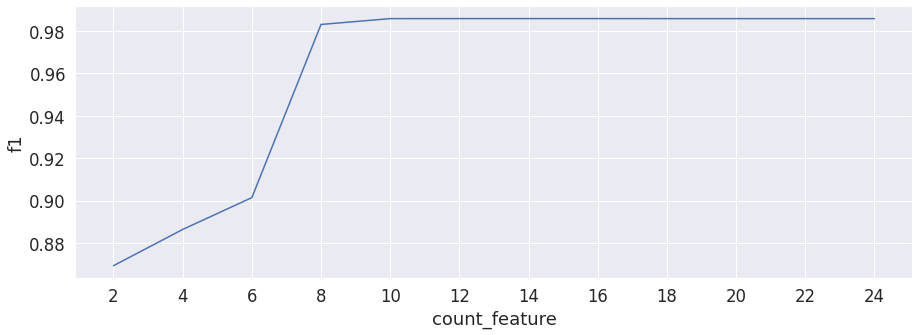

In [ ]:
%%time
res_rf = select_feature(model_RF, X_train.copy(), y_train.copy(), list(range(2, 25, 2)))

In [ ]:
select_k_best_classifier = SelectKBest(mutual_info_classif, 15)

In [ ]:
X_train_rf = select_k_best_classifier.fit_transform(X_train, y_train)
X_train_rf = pd.DataFrame(X_train_rf, columns = list(X_train.columns[select_k_best_classifier.get_support()]))

X_test_rf = select_k_best_classifier.transform(X_test)
X_test_rf = pd.DataFrame(X_test_rf, columns = list(X_test.columns[select_k_best_classifier.get_support()]))

In [ ]:
X_train_rf.head()

,Pclass,Title_1,Title_2,Title_3,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_4,Embarked_1
0,3.0,1.0,0.0,0.0,0.0,32.580205,1.0,0.0,0.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,3.0,1.0,0.0,0.0,0.0,34.000000,1.0,0.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0
2,3.0,1.0,0.0,0.0,0.0,27.000000,1.0,0.0,0.0,0.0,6.9750,1.0,0.0,0.0,1.0
3,3.0,0.0,1.0,0.0,1.0,45.000000,2.0,1.0,0.0,1.0,14.4542,1.0,0.0,0.0,0.0
4,3.0,1.0,0.0,0.0,0.0,32.000000,1.0,0.0,0.0,0.0,8.0500,0.0,1.0,0.0,1.0


In [ ]:
model_RF = RandomForestClassifier(n_jobs = -1, n_estimators = 300)
parameters_RF = {'criterion':('entropy', 'gini'), 'max_depth':[3, 4, 5, 6, 7, None]}

In [ ]:
%%time
clf = GridSearchCV(estimator = model_RF, param_grid = parameters_RF, cv = 5, scoring = "f1")
clf.fit(X_train_rf, y_train)

CPU times: user 23.9 s, sys: 1.83 s, total: 25.7 s
Wall time: 42.9 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'entropy', 'max_depth': 5}
0.7708549083787605


In [ ]:
model_RF = RandomForestClassifier(n_jobs = -1, n_estimators = 300, criterion = 'entropy', max_depth = 5)

In [ ]:
model_RF.fit(X_train_rf, y_train)
pred_rf = model_RF.predict(X_test_rf)

In [ ]:
f1_score_rf = f1_score(y_test, pred_rf)
f1_score_rf

0.7812499999999999

In [ ]:
confusion_matrix(y_test, pred_rf)

array([[101,   9],
       [ 19,  50]])

## Градиентный бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X_train.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Title_5,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Deck_9,Embarked_1,Embarked_2,Embarked_3
0,2,1,0,0,0,0,1,57.00000,1,0,0,0,10.50,1,0,0,0,0,0,0,0,0,1,0,0
1,2,0,1,0,0,0,0,36.53317,1,0,0,0,0.00,0,1,0,0,0,0,0,0,0,1,0,0
2,1,0,0,1,0,0,1,33.00000,2,1,1,0,90.00,0,0,1,0,0,0,0,0,0,0,1,0
3,3,0,1,0,0,0,0,18.00000,1,0,0,0,7.75,0,1,0,0,0,0,0,0,0,1,0,0
4,3,1,0,0,0,0,1,26.00000,2,1,1,0,16.10,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
model_GB = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05)

CPU times: user 18.3 s, sys: 1 ms, total: 18.3 s
Wall time: 18.4 s


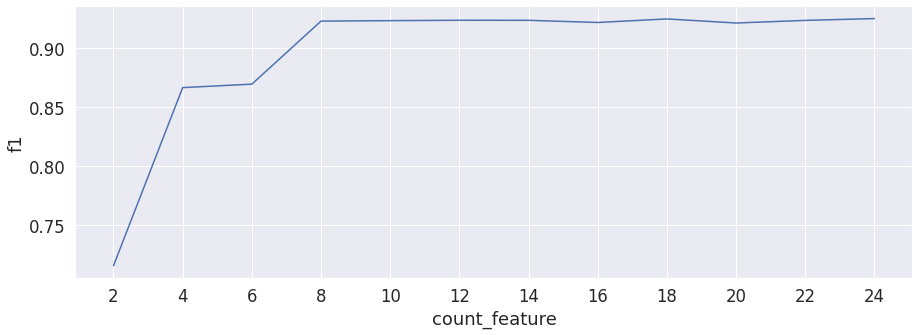

In [ ]:
%%time
res_gb = select_feature(model_GB, X_train.copy(), y_train.copy(), list(range(2, 25, 2)))

In [ ]:
select_k_best_classifier = SelectKBest(mutual_info_classif, 18)

In [ ]:
X_train_gb = select_k_best_classifier.fit_transform(X_train, y_train)
X_train_gb = pd.DataFrame(X_train_gb, columns = list(X_train.columns[select_k_best_classifier.get_support()]))

X_test_gb = select_k_best_classifier.transform(X_test)
X_test_gb = pd.DataFrame(X_test_gb, columns = list(X_test.columns[select_k_best_classifier.get_support()]))

In [ ]:
X_train_gb.head()

,Pclass,Title_1,Title_2,Title_3,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck_2,Deck_3,Deck_5,Deck_7,Deck_9,Embarked_1,Embarked_2
0,2.0,1.0,0.0,0.0,1.0,57.00000,1.0,0.0,0.0,0.0,10.50,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,0.0,1.0,0.0,0.0,36.53317,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,1.0,33.00000,2.0,1.0,1.0,0.0,90.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,0.0,1.0,0.0,0.0,18.00000,1.0,0.0,0.0,0.0,7.75,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.0,1.0,0.0,0.0,1.0,26.00000,2.0,1.0,1.0,0.0,16.10,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
parameters_GB = {'loss':('deviance', 'exponential'), 'max_depth':[3, 4, 5, 6, 7]}
model_GB = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05)

In [ ]:
%%time
clf = GridSearchCV(estimator = model_GB, param_grid = parameters_GB, cv = 5, scoring = "f1")
clf.fit(X_train_rf, y_train)

CPU times: user 28.2 s, sys: 0 ns, total: 28.2 s
Wall time: 28.2 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'loss': 'deviance', 'max_depth': 3}
0.7596438544953396


In [ ]:
model_GB = GradientBoostingClassifier(n_estimators = 300, loss = 'deviance', max_depth = 4)

In [ ]:
model_GB.fit(X_train_gb, y_train)
pred_gb = model_GB.predict(X_test_gb)

In [ ]:
f1_score_gb = f1_score(y_test, pred_gb)
f1_score_gb

0.6717557251908397

In [ ]:
confusion_matrix(y_test, pred_gb)

array([[92, 18],
       [25, 44]])

## Catboost

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostClassifier

In [ ]:
model_CatB = CatBoostClassifier(verbose = False)

CPU times: user 1min 18s, sys: 9.01 s, total: 1min 27s
Wall time: 58.1 s


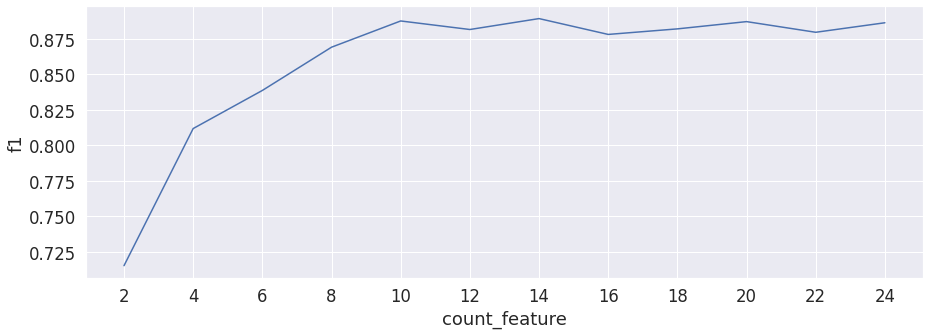

In [ ]:
%%time
res_CatB = select_feature(model_CatB, X_train.copy(), y_train.copy(), list(range(2, 25, 2)))

In [ ]:
res_CatB

14

In [ ]:
select_k_best_classifier = SelectKBest(mutual_info_classif, 14)

X_train_CatB = select_k_best_classifier.fit_transform(X_train, y_train)
X_train_CatB = pd.DataFrame(X_train_CatB, columns = list(X_train.columns[select_k_best_classifier.get_support()]))

X_test_CatB = select_k_best_classifier.transform(X_test)
X_test_CatB = pd.DataFrame(X_test_CatB, columns = list(X_test.columns[select_k_best_classifier.get_support()]))

In [ ]:
X_train_CatB.head()

,Pclass,Title_1,Title_2,Title_3,Title_4,Sex,Age,Fsize,SibSp,Fare,Deck_2,Deck_4,Deck_6,Embarked_1
0,2.0,1.0,0.0,0.0,0.0,1.0,57.00000,1.0,0.0,10.50,0.0,0.0,0.0,1.0
1,2.0,0.0,1.0,0.0,0.0,0.0,36.53317,1.0,0.0,0.00,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0,33.00000,2.0,1.0,90.00,0.0,0.0,0.0,0.0
3,3.0,0.0,1.0,0.0,0.0,0.0,18.00000,1.0,0.0,7.75,1.0,0.0,0.0,1.0
4,3.0,1.0,0.0,0.0,0.0,1.0,26.00000,2.0,1.0,16.10,1.0,0.0,0.0,1.0


In [ ]:
model_CatB = CatBoostClassifier(verbose = False)
parameters_CatB = {'bagging_temperature':[3, 4, 5, 6, 7]}

In [ ]:
%%time
clf = GridSearchCV(estimator = model_CatB, param_grid = parameters_CatB, cv = 5, scoring = "f1")
clf.fit(X_train_CatB, y_train)

CPU times: user 43.4 s, sys: 3.77 s, total: 47.2 s
Wall time: 30.8 s


In [ ]:
print(clf.best_params_)
print(clf.best_score_)

{'bagging_temperature': 3}
0.7517723427362885


In [ ]:
model_CatB = CatBoostClassifier(verbose = False, bagging_temperature = 3)

In [ ]:
model_CatB.fit(X_train_CatB, y_train)
pred_CatB = model_CatB.predict(X_test_CatB)

In [ ]:
f1_score_CatB = f1_score(y_test, pred_CatB)
f1_score_CatB

0.7258064516129032

In [ ]:
confusion_matrix(y_test, pred_CatB)

array([[100,  10],
       [ 24,  45]])

## Сравниваем модели

In [ ]:
f1_score_list = [f1_score_rf, f1_score_knn, f1_score_svm, f1_score_gb, f1_score_CatB]
name_f1_score_list = ['rf', 'knn', 'svm', 'gb', 'catboost']

In [ ]:
f1_score_list

[0.7812499999999999, 0.7555555555555555, 0.7938931297709925]

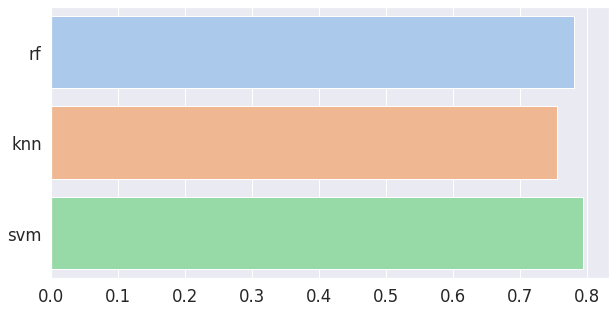

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y = name_f1_score_list, x = f1_score_list, palette = 'pastel', orient = 'h');

#Сложный вариант

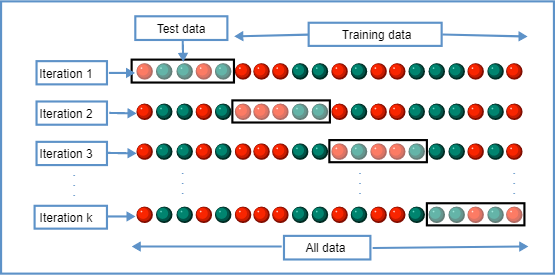

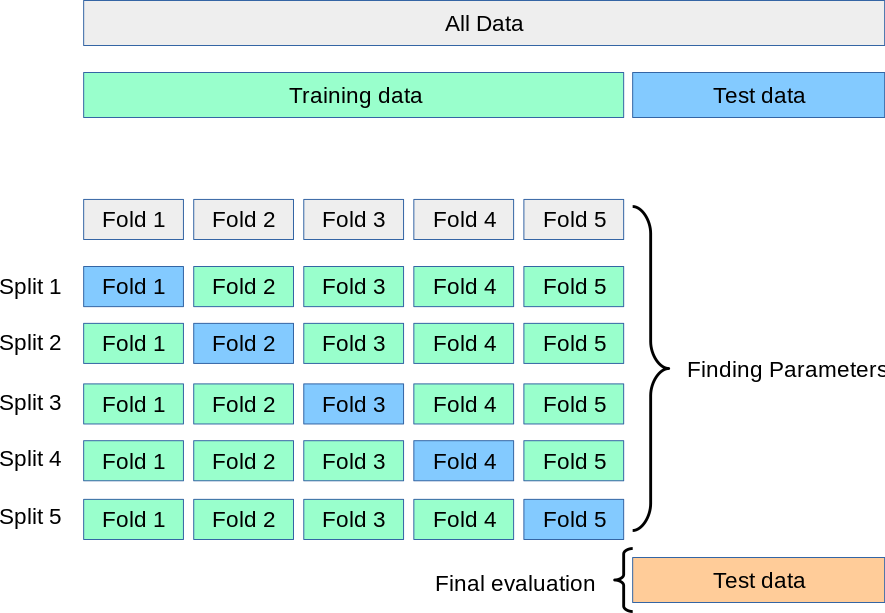

Загружаем данные

In [ ]:
path = "/content/gdrive/MyDrive/ML/Datasets/titanic/train.csv"
data = pd.read_csv(path, sep = ",")

X = data.drop(["Survived"], axis = 1)     # Резделим признаки и целевую переменную, это необходимо для удобства использования методов анализа данных.
y = data.Survived

In [ ]:
skf = KFold(n_splits = 5)

## Случайный лес

In [ ]:
model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
parameters = {'max_depth':[3, 4, 5, 6, 7, None]}

In [ ]:
%%time
f1_rf = []

for train_index, test_index in skf.split(y):
  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_test = y_test.reset_index(drop = True)

  X_train, X_test = preProcess_train_test(X_train, X_test) # Делаем предварительную обработку
  k_best_for_model = select_feature(model, X_train.copy(), y_train.copy(), list(range(2, X_train.shape[1] + 1, 2)), plot_flag = False) # Считаем оптимальное число лучших признаков
  X_train, X_test = n_best(X_train, X_test, y_train, k_best_for_model)    # Сокращаем количество признаков

  clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = "f1")
  clf.fit(X_train, y_train)    # Подбираем гиперпараметры модели

  clf.best_estimator_.fit(X_train, y_train)  # Тестируем модель
  pred = clf.best_estimator_.predict(X_test)
  f1_rf.append(f1_score(y_test, pred))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
CPU times: user 1min 54s, sys: 2.01 s, total: 1min 56s
Wall time: 1min 59s


## Метод опорных векторов

In [ ]:
model = SVC(kernel = 'linear')
parameters = {'C':[.3, .4, .5, .6, .7, 1, 1.5]}

In [ ]:
%%time
f1_svm = []

for train_index, test_index in skf.split(y):
  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_test = y_test.reset_index(drop = True)

  X_train, X_test = preProcess_train_test(X_train, X_test) # Делаем предварительную обработку

  columns_name = X_train.columns
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train) 
  X_test = scaler.transform(X_test)
  X_train = pd.DataFrame(X_train, columns = columns_name) 
  X_test = pd.DataFrame(X_test, columns = columns_name) 

  k_best_for_model = select_feature(model, X_train.copy(), y_train.copy(), list(range(2, X_train.shape[1] + 1, 2)), plot_flag = False) # Считаем оптимальное число лучших признаков
  X_train, X_test = n_best(X_train, X_test, y_train, k_best_for_model)    # Сокращаем количество признаков

  clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = "f1")
  clf.fit(X_train, y_train)    # Подбираем гиперпараметры модели

  clf.best_estimator_.fit(X_train, y_train)  # Тестируем модель
  pred = clf.best_estimator_.predict(X_test)

  f1_svm.append(f1_score(y_test, pred))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
CPU times: user 39.2 s, sys: 1.99 s, total: 41.2 s
Wall time: 44.3 s


## k-ближайщих соседа

In [ ]:
parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 4, 5, 6, 7], 'algorithm':["auto", "ball_tree", "kd_tree", "brute"], "p":[1, 2, 3, 4, 5]}
model = KNeighborsClassifier(n_jobs = -1)

In [ ]:
%%time
f1_knn = []

for train_index, test_index in skf.split(y):
  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_test = y_test.reset_index(drop = True)

  X_train, X_test = preProcess_train_test(X_train, X_test) # Делаем предварительную обработку

  columns_name = X_train.columns
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train) 
  X_test = scaler.transform(X_test)
  X_train = pd.DataFrame(X_train, columns = columns_name) 
  X_test = pd.DataFrame(X_test, columns = columns_name) 

  k_best_for_model = select_feature(model, X_train.copy(), y_train.copy(), list(range(2, X_train.shape[1] + 1, 2)), plot_flag = False) # Считаем оптимальное число лучших признаков
  X_train, X_test = n_best(X_train, X_test, y_train, k_best_for_model)    # Сокращаем количество признаков

  clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = "f1")
  clf.fit(X_train, y_train)    # Подбираем гиперпараметры модели

  clf.best_estimator_.fit(X_train, y_train)  # Тестируем модель
  pred = clf.best_estimator_.predict(X_test)
  
  f1_knn.append(f1_score(y_test, pred))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
CPU times: user 2min 42s, sys: 29.2 s, total: 3min 11s
Wall time: 5min 11s


## Градиентный бустинг

In [ ]:
model = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.05)
parameters = {'loss':('deviance', 'exponential'), 'max_depth':[3, 4, 5, 6, 7]}

In [ ]:
%%time
f1_gb = []

for train_index, test_index in skf.split(y):
  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_test = y_test.reset_index(drop = True)

  X_train, X_test = preProcess_train_test(X_train, X_test) # Делаем предварительную обработку
  k_best_for_model = select_feature(model, X_train.copy(), y_train.copy(), list(range(2, X_train.shape[1] + 1, 2)), plot_flag = False) # Считаем оптимальное число лучших признаков
  X_train, X_test = n_best(X_train, X_test, y_train, k_best_for_model)    # Сокращаем количество признаков

  clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = "f1")
  clf.fit(X_train, y_train)    # Подбираем гиперпараметры модели

  clf.best_estimator_.fit(X_train, y_train)  # Тестируем модель
  pred = clf.best_estimator_.predict(X_test)
  f1_gb.append(f1_score(y_test, pred))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
CPU times: user 4min 42s, sys: 1.8 s, total: 4min 44s
Wall time: 4min 48s


## Catboost

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostClassifier

In [ ]:
model = CatBoostClassifier(verbose = False)
parameters = {'bagging_temperature':[3, 4, 5, 6, 7]}

In [ ]:
%%time
f1_cb = []

for train_index, test_index in skf.split(y):
  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]
  X_train = X_train.reset_index(drop = True)
  y_train = y_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_test = y_test.reset_index(drop = True)

  X_train, X_test = preProcess_train_test(X_train, X_test) # Делаем предварительную обработку
  k_best_for_model = select_feature(model, X_train.copy(), y_train.copy(), list(range(2, X_train.shape[1] + 1, 2)), plot_flag = False) # Считаем оптимальное число лучших признаков
  X_train, X_test = n_best(X_train, X_test, y_train, k_best_for_model)    # Сокращаем количество признаков

  clf = GridSearchCV(estimator = model, param_grid = parameters, cv = 5, scoring = "f1")
  clf.fit(X_train, y_train)    # Подбираем гиперпараметры модели

  clf.best_estimator_.fit(X_train, y_train)  # Тестируем модель
  pred = clf.best_estimator_.predict(X_test)
  f1_cb.append(f1_score(y_test, pred))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
CPU times: user 11min 38s, sys: 1min 6s, total: 12min 45s
Wall time: 8min 34s


## Сравниваем модели

In [ ]:
f1_all = f1_rf + f1_svm + f1_knn + f1_gb + f1_cb
name_all = ['rf'] * len(f1_rf) + ['svm'] * len(f1_rf) + ['knn'] * len(f1_rf) + ['gb'] * len(f1_rf) + ['cb'] * len(f1_rf)

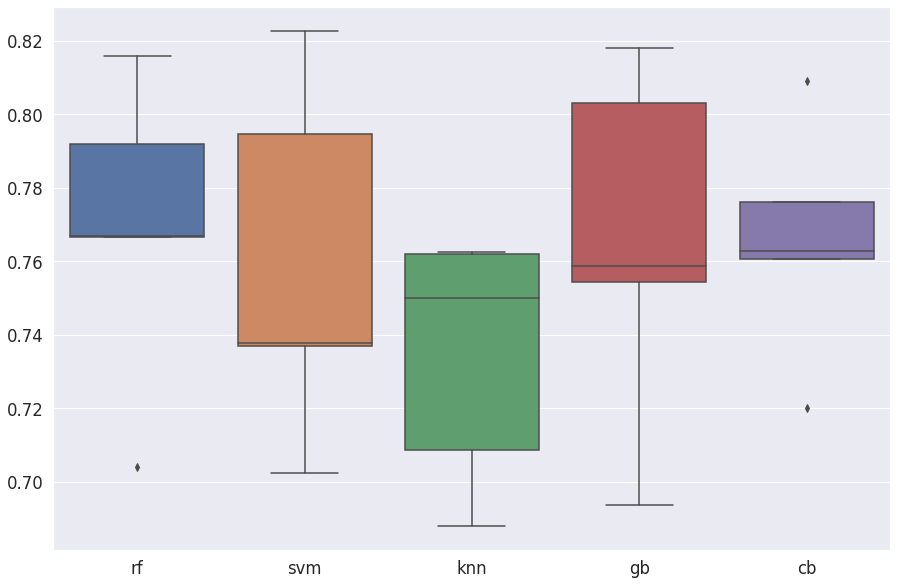

In [ ]:
sns.set_theme(style = "whitegrid")
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.boxplot(x = name_all, y = f1_all)

#Почему все любят Catboost?

In [ ]:
path = "/content/gdrive/MyDrive/ML/Datasets/titanic/train.csv"
data = pd.read_csv(path, sep = ",")        

In [ ]:
X = data.drop(["Survived"], axis = 1)     # Резделим признаки и целевую переменную, это необходимо для удобства использования методов анализа данных.
y = data.Survived

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,282,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S
1,500,3,"Svensson, Mr. Olof",male,24.0,0,0,350035,7.7958,NaN,S
2,86,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.8500,NaN,S
3,152,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
4,156,1,"Williams, Mr. Charles Duane",male,51.0,0,1,PC 17597,61.3792,NaN,C


In [ ]:
def preProcess_train_test_catboost(train, test):
  train = PreProcess_for_Name(train, "Name")
  test = PreProcess_for_Name(test, "Name")

  rare_title = train.Title.value_counts()[train.Title.value_counts() < 20].index  # Эта переменная нам ещё понадобиться, ведь редкие обращения могут быть и в тестовых данных.
  train.Title = train.Title.replace(rare_title, 'Rare Title')
  test.Title = test.Title.replace(rare_title, 'Rare Title')

  train = count_family(train, ["SibSp", "Parch"])
  test = count_family(test, ["SibSp", "Parch"])

  train = select_deck(train, "Cabin")
  test = select_deck(test, "Cabin")

  train = train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)
  test = test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis = 1)

  misscat = imv.Catman()
  misscat.fit(train.copy())

  train = misscat.transform(train.copy())
  test = misscat.transform(test.copy())

  train = Sex_and_FsizeDiscrete_encoding(train)
  test = Sex_and_FsizeDiscrete_encoding(test)

  return(train, test)

In [ ]:
X_train, X_test = preProcess_train_test_catboost(X_train, X_test)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


In [ ]:
X_train.head()

,Pclass,Title,Sex,Age,Fsize,FsizeDiscrete,SibSp,Parch,Fare,Deck,Embarked
0,3,Mr,0,28.0,1,0,0,0,7.8542,X,S
1,3,Mr,0,24.0,1,0,0,0,7.7958,X,S
2,3,Mrs,1,33.0,4,1,3,0,15.8500,X,S
3,1,Mrs,1,22.0,2,1,1,0,66.6000,C,S
4,1,Mr,0,51.0,2,1,0,1,61.3792,X,C


In [ ]:
object_list_feature = list(X_train.select_dtypes(include = 'object').columns)
cat_vars = [X_train.columns.get_loc(c) for c in object_list_feature if c in X_train]

In [ ]:
cat_vars

[1, 9, 10]

In [ ]:
model = CatBoostClassifier(verbose = False)

In [ ]:
model.fit(X_train, y_train, cat_features = cat_vars)  # Тестируем модель
pred = model.predict(X_test)

f1_score(y_test, pred)

0.7737226277372262